# Kalman Filter

    Ben Christensen
    Math 405
    March 26, 2019

In [1]:
import numpy as np
from numpy.random import multivariate_normal
from matplotlib import pyplot as plt
from scipy import linalg as la

## Problem 1

In [2]:
class KalmanFilter(object):
    def __init__(self, F, Q, H, R, u):
        """
        Initialize the dynamical systems models.
        
        Parameters
        ----------
        F: ndarray of shape (n,n)
           The state transition model.
        Q: ndarray of shape (n,n)
           The covariance matrix for the state noise.
        H: ndarray of shape (m,n)
           The observation model.
        R: ndarray of shape (m,m)
           The covariance matrix for observation noise.
        u: ndarray of shape (n,)
           The control vector.
        """
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
        
    def evolve(self, x0, N):
        """
        Compute the first N states and observations generated by the Kalman
            system.
        Parameters
        ----------
        x0: ndarray (n,)
            The initial state
        N: integer
            The number of time steps to evolve.
        
        Returns
        -------
        states: ndarray of shape (n,N)
            States 0 through N-1, given by each column.
        obs: ndarray of shape (m,N)
            Observations 0 through N-1, given by each column.
        """
        xk = x0
        states = [xk]
        obs = [self.H@xk + multivariate_normal([0,0], self.R)]
        for i in range(1, N):
            #Calculate xk using the linear dynamical system
            xk = self.F@xk + self.u + multivariate_normal(np.zeros(4), self.Q)
            states.append(xk)
            #Calculate the observation
            obs.append(self.H@xk + multivariate_normal([0,0], self.R))
        #Transpose the arrays so that each column is a state or obs
        return np.array(states).T, np.array(obs).T
    
    def estimate(self, x, P, z):
        """
        Compute the state estimates using the Kalman filter.
        If x and P correspond to time step k, then z is a sequence of
        observations starting at time step k+1.
        
        Parameters
        ----------
        x : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape (m,N)
            Sequence of N observations (each column is an obs.).
            
        Returns
        -------
        out : ndarray of shape(n,N)
            Sequence of state estimates (each column is an est.).
        """
        I = np.eye(4)
        states = []
        x_hat = x
        for i in range(len(z.T)):
            #Predict
            x_hat = self.F@x_hat + self.u
            P = self.F@P@self.F.T + self.Q
            #Update
            y = z.T[i] - self.H@x_hat
            S = self.H@P@self.H.T + self.R
            K = P@self.H.T@la.inv(S)
            x_hat += K@y
            P = (I-K@self.H)@P
            states.append(x_hat)
        #Transpose states so each column is an est.
        return np.array(states).T
    
    def predict(self, x, k):
        """
        Predict the next k states in the absence of observations.
        
        Parameters
        ----------
        x: ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.
        
        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        predictions = []
        x_1 = x
        for i in range(k):
            x_1 = self.F@x_1 + self.u
            predictions.append(x_1)
            
        return np.array(predictions)
    
    def rewind(self, x, k):
        """
        Predict the k states preceding the current state estimate x.
        
        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number preceding states to predict.
            
        Returns
        -------
        out : ndarray of shape (n,k)
            The k preceding predicted states.
        """
        predictions = []
        x_0 = x
        for i in range(k):
            x_0 = la.inv(self.F)@(x_0 - self.u)
            predictions.append(x_0)
        
        return np.array(predictions)
            

## Problem 2

In [3]:
#Initialize the Kalman Filter
Q = .1*np.eye(4)
R = 5000*np.eye(2)
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])
F = np.array([[1, 0, .1, 0],
              [0, 1, 0, .1], 
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
u = np.array([0, 0, 0, -.98])
KF = KalmanFilter(F, Q, H, R, u)
#Evolve the projectile with an initial condition and number of 
#    time steps
x0 = np.array([0, 0, 300, 600])
N = 1250
states, obs = KF.evolve(x0, N)

## Problem 3

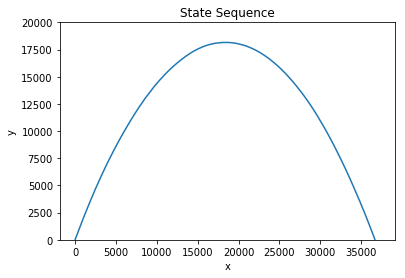

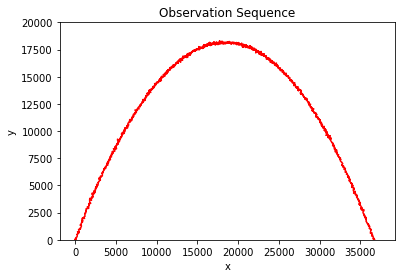

In [4]:
state_x, state_y = states[0], states[1]
obs_x, obs_y = obs[0], obs[1]
#Plot the state sequence
plt.plot(state_x, state_y)
plt.title("State Sequence")
plt.ylabel('y')
plt.xlabel('x')
plt.ylim(0, 20000)
plt.show()
#Plot the observation sequence
plt.plot(obs_x, obs_y, color='red')
plt.title("Observation Sequence")
plt.ylabel('y')
plt.xlabel('x')
plt.ylim(0, 20000)
plt.show()

## Problem 5

In [5]:
#Approximate the velocities
Vx, Vy = np.mean(np.diff(obs[:,199:208], 1)/.1, axis=1)
x0 = obs[:,199]
x0 = np.concatenate((x0,[Vx], [Vy]))

In [6]:
P = 10**6*Q

In [7]:
estimates = KF.estimate(x0, P, obs[:,199:])

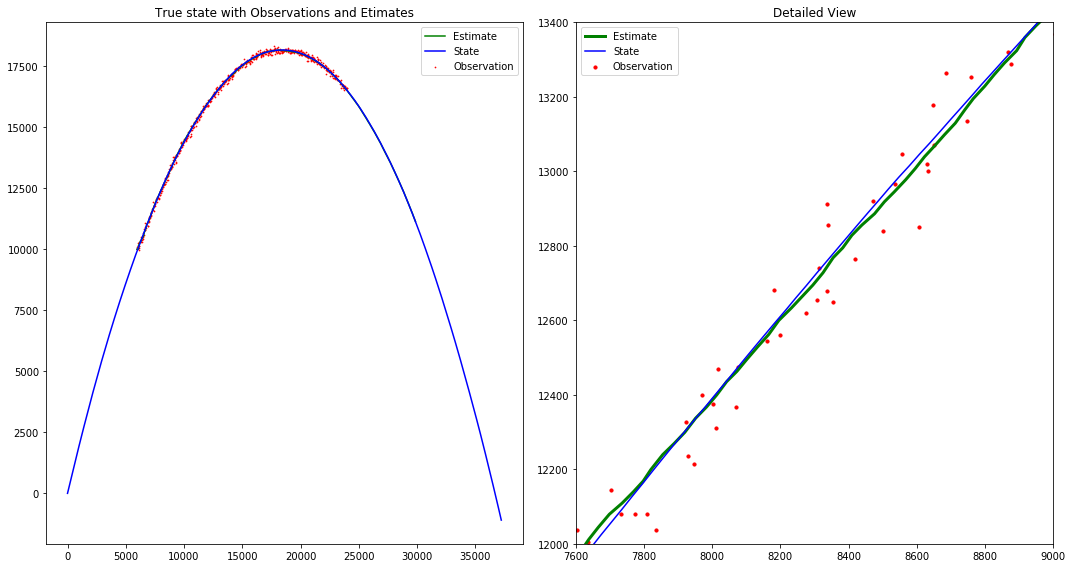

In [8]:
plt.figure(figsize=(15,8))
#Graph the estaimtes with observation and state sequence
plt.subplot(121)
plt.scatter(obs[0,199:800], obs[1,199:800], color='red', s=.5, label="Observation")
plt.plot(estimates[0,:800], estimates[1,:800], color='green', label="Estimate")
plt.plot(state_x, state_y, color='blue', label="State")
plt.legend()
plt.title("True state with Observations and Etimates")
#Same graph but smaller window
plt.subplot(122)
plt.scatter(obs[0,199:800], obs[1,199:800], color='red', s=10, label="Observation")
plt.plot(estimates[0,:800], estimates[1,:800], color='green', linewidth=3, label="Estimate")
plt.plot(state_x, state_y, color='blue', label="State")
plt.xlim(7600, 9000)
plt.ylim(12000, 13400)
plt.title("Detailed View")
plt.legend()
plt.tight_layout()
plt.show()

## Problem 7

In [16]:
#Calculate predictions
x = estimates[:,799]
prediction = KF.predict(x, 250)

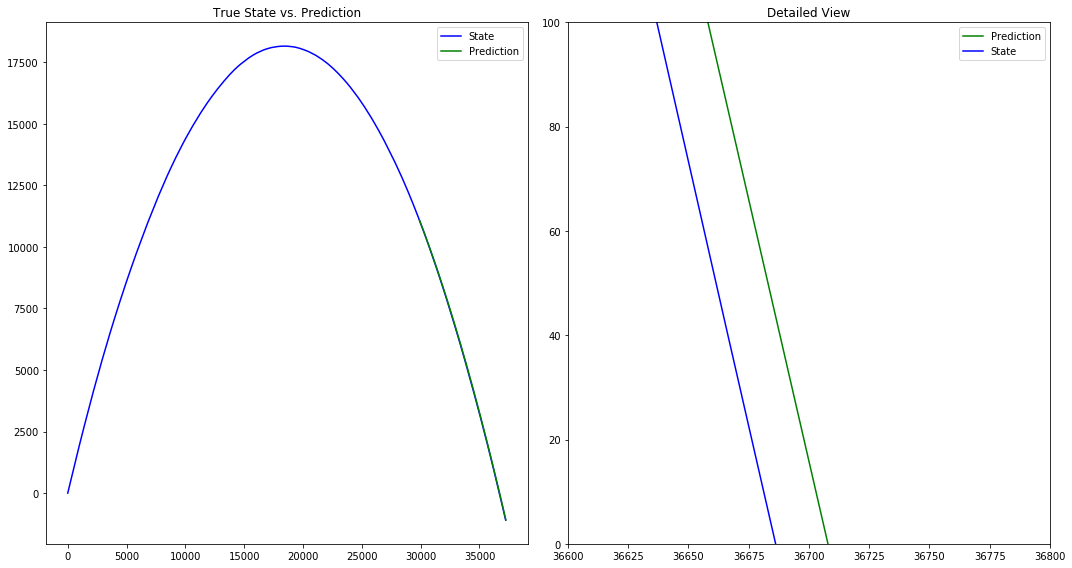

In [23]:
plt.figure(figsize=(15,8))
#Graph the prediction against the true state sequence
plt.subplot(121)
plt.plot(state_x, state_y, color='blue', label="State")
plt.plot(prediction[:,0], prediction[:,1], color='green', label="Prediction")
plt.legend()
plt.title("True State vs. Prediction")
#Same graph but smaller window
plt.subplot(122)
plt.plot(prediction[:,0], prediction[:,1], color='green', label="Prediction")
plt.plot(state_x, state_y, color='blue', label="State")
plt.xlim(36600, 36800)
plt.ylim(0, 100)
plt.title("Detailed View")
plt.legend()
plt.tight_layout()
plt.show()

## Problem 9

In [11]:
x = estimates[:,249]
prediction = KF.rewind(x, 450)

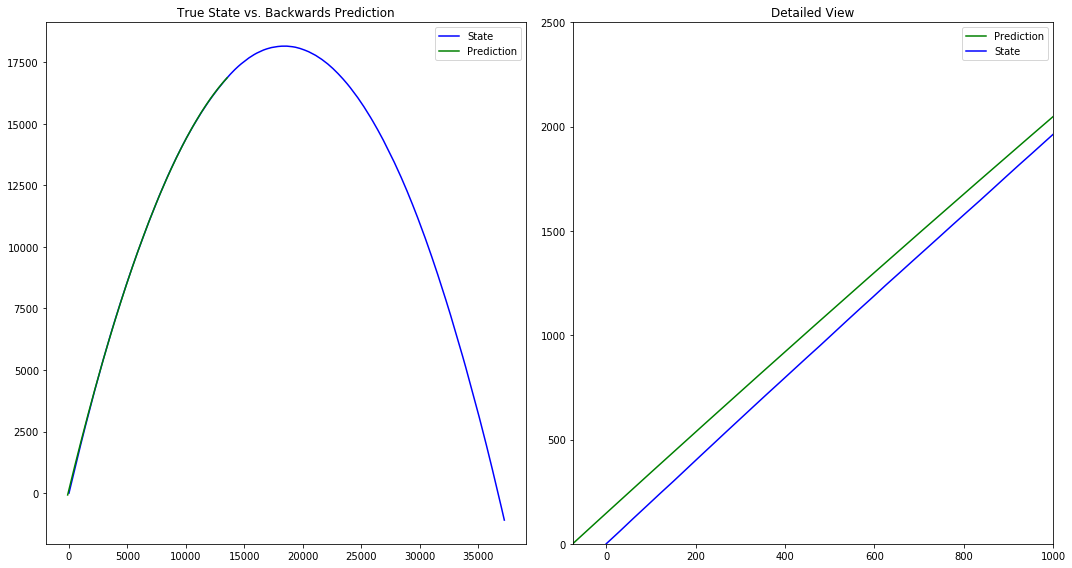

In [12]:
plt.figure(figsize=(15,8))
#Graph the rewind prediction against the true state sequence
plt.subplot(121)
plt.plot(state_x, state_y, color='blue', label="State")
plt.plot(prediction[:,0], prediction[:,1], color='green', label="Prediction")
plt.legend()
plt.title("True State vs. Backwards Prediction")
#Same graph but smaller window
plt.subplot(122)
plt.plot(prediction[:,0], prediction[:,1], color='green', label="Prediction")
plt.plot(state_x, state_y, color='blue', label="State")
plt.xlim(-75, 1000)
plt.ylim(0, 2500)
plt.title("Detailed View")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
x = estimates[:,599]
prediction = KF.rewind(x, 850)

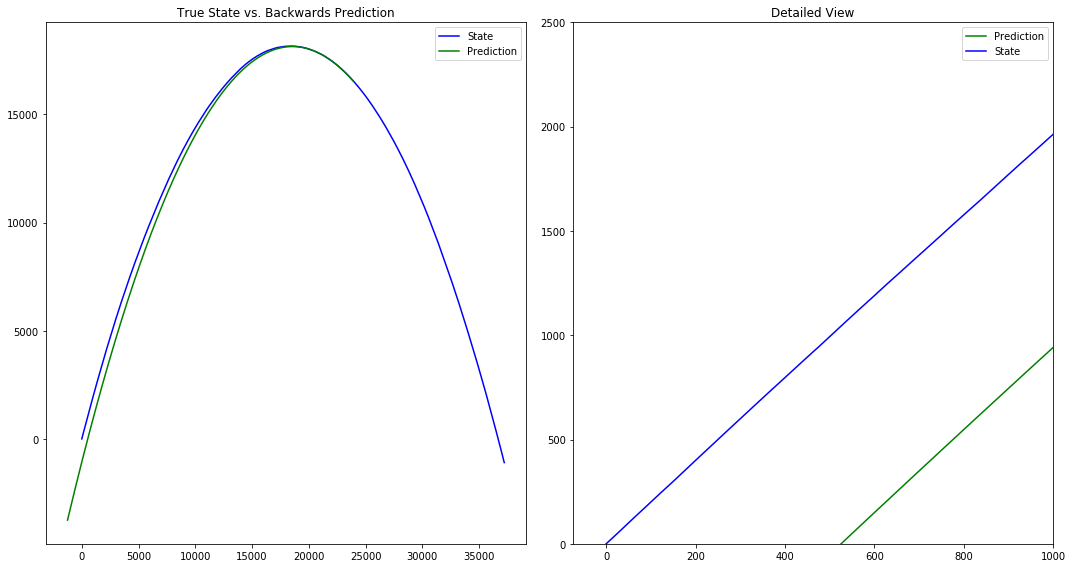

In [14]:
plt.figure(figsize=(15,8))
#Graph the prediction against the true state sequence
plt.subplot(121)
plt.plot(state_x, state_y, color='blue', label="State")
plt.plot(prediction[:,0], prediction[:,1], color='green', label="Prediction")
plt.legend()
plt.title("True State vs. Backwards Prediction")
#Same graph but smaller window
plt.subplot(122)
plt.plot(prediction[:,0], prediction[:,1], color='green', label="Prediction")
plt.plot(state_x, state_y, color='blue', label="State")
plt.xlim(-75, 1000)
plt.ylim(0, 2500)
plt.title("Detailed View")
plt.legend()
plt.tight_layout()
plt.show()

The backwards prediction starting with an earlier estimate is more accurate. This makes sense because we are predicting fewer points. 